In [1]:
import os
import re
import numpy as np
import time
import random
import pandas as pd
import glob
import shutil
import seaborn as sns
import itertools
import math
from pathlib import Path
import json
from copy import deepcopy
from dataclasses import dataclass
from types import SimpleNamespace

from matplotlib.lines import Line2D
from scipy.integrate import solve_ivp
from sklearn.metrics import confusion_matrix
from scipy.stats import gaussian_kde
from autocatalytic_cores_lib import *
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sympy import symbols, Matrix, diff, lambdify
from scipy.linalg import eigvals
from numpy.linalg import svd
from scipy.linalg import pinv
from scipy.optimize import nnls
from numpy.linalg import matrix_rank
from scipy.optimize import linprog
from scipy.sparse import csr_matrix
from scipy.sparse import bmat
from scipy.sparse.csgraph import connected_components
from scipy.linalg import eigh
from scipy.optimize import fsolve
from textwrap import dedent
import networkx as nx   
from matplotlib import animation

In [2]:
def Construct_Kinetics(N_X, N_Y, N_R, S_plus, S_minus, degradation=False):
    """
      - concentration X0
      - Initial concentration Y0
      - Generalized Forward Rate constant kf
      - Degradation kd
    """
    X0 = [2.0 * random.uniform(0.95, 1.05) for _ in range(N_X)]
    Y0 = [0.01 * random.uniform(0.95, 1.05) for _ in range(N_Y)]
    ini_concentration = np.array(X0 + Y0)

    kf = np.array([random.uniform(1.0, 4.0) for _ in range(N_R)])
    # X‐part:
    for l in range(N_R):
        prodX = 1.0
        for i in range(N_X):
            p = S_minus[i, l]
            if p>0:
                prodX *= X0[i]**p
        kf = kf * prodX
        
    kf /= kf.max()
    
    # degradation degradation coefficient
    kd = None
    if degradation:
        kd = 0.01 * np.array([random.uniform(0.95, 1.05) for _ in range(N_Y)])

    return np.array(Y0), kf, kd

def make_dydt_rescaled_func(N_X, N_Y, N_R, S_minus, S_plus, kf, kd, law):
    mus = []
        
    # net stoichiometry in the free (Y) part for each reaction l
    netStoich_Y = np.zeros(N_R, dtype=int)
    for l in range(N_R):
        netStoich_Y[l] = int(np.sum(S_plus[N_X:, l]) - np.sum(S_minus[N_X:, l]))

    def dydt_rescaled(t, Y_star_full):
        Ys = Y_star_full[:N_Y]      # normalized Y^*(t)
        logN = Y_star_full[-1]      # logN(t)

        net_flux = np.zeros(N_R)

        for l in range(N_R):
            # --- forward flux density using Ystar ---
            prodY = 1.0
            for j in range(N_Y):
                p = S_minus[N_X+j, l]
                if p>0:
                    prodY *= Ys[j]**p

            if np.sum(S_minus[N_X:, l])==0:
                v_f = 0.0
            else:
                if law=="MM":
                    Kf = prodY
                    v_f = 0.0 if (kf[l]+Kf)==0 else Kf/(kf[l]+Kf)
                else:
                    v_f = kf[l]*prodY

            net_flux[l] = v_f
            
        mu_t = float(np.dot(net_flux, netStoich_Y))
        mus.append(mu_t)

        # dY*/dt
        dYs = np.zeros(N_Y)
        for j in range(N_Y):
            row = S_plus[N_X+j,:] - S_minus[N_X+j,:]
            dYs[j] = float(np.dot(row, net_flux)) - mu_t*Ys[j]

        # d(logN)/dt = μ(t)
        return np.concatenate([dYs, [mu_t]])

    return dydt_rescaled, mus
    
def Solve_Scaled_System(S_minus, S_plus, Y0, N_X, N_Y, N_R,
                        kf, kd, law, dt, n_steps):
    """
    Fix step dt，simulate n_steps：
      - t_eval      (length = n_steps+1)
      - Ystar_traj  (shape (N_Y, n_steps+1))
      - Yabs_traj   (shape (N_Y, n_steps+1))
      - mus         (length = n_steps+1)
      - N_traj      (length = n_steps+1)
    """
    # initialize N, normalize Y*
    N0 = np.sum(Y0)
    Ystar0 = Y0 / N0
    logN0 = math.log(N0)
    y0 = np.concatenate([Ystar0, [logN0]])

    ttot = dt * n_steps
    t_eval = np.linspace(0, ttot, n_steps + 1)

    dydt_rescaled, mus = make_dydt_rescaled_func(
        N_X, N_Y, N_R, S_minus, S_plus, kf, kd, law
    )

    sol = solve_ivp(
        fun=lambda t, y: dydt_rescaled(t, y),
        t_span=[0, ttot],
        y0=y0,
        method="LSODA",
        t_eval=t_eval,
        rtol=1e-6,
        atol=1e-8
    )

    Ystar_traj = sol.y[:N_Y, :]             # normalize Y^*(t)
    logN_traj = sol.y[N_Y, :]               # logN(t)
    N_traj = np.exp(logN_traj)              # exact N(t)
    Yabs_traj = Ystar_traj * N_traj         # exact Y(t) = N(t)*Y^*(t)

    return t_eval, Ystar_traj, Yabs_traj, mus, N_traj

# =============================================================================
# long-term growth rate
# =============================================================================
def compute_long_term_growth_rate(mus, last_n=100):
    """
    Average the last last_n values of the mu(t) sequence to obtain an estimate of the exponential growth rate λ
    """
    if len(mus) < last_n:
        return np.mean(mus)
    return np.mean(mus[-last_n:])
    
    
def compute_shannon_entropy(Y: np.ndarray, clip_tol: float = 1e-12, eps: float = 1e-10) -> float:
    """
    Given a set of non-negative Y concentrations, 
    first normalize them as p_i = Y_i / sum(Y_i), 
    then calculate the Shannon entropy H = -sum_i p_i * log(p_i). 
    If sum(Y) == 0, return 0.
    eps is used to avoid log(0) or numerical underflow.
    """
    Y = np.asarray(Y, float)

    # Correct minor negative drift or underflow
    Y = np.where(Y < clip_tol, 0.0, Y)

    total = Y.sum()
    if total <= 0:
        return 0.0

    # Normalization
    p = Y / total

    # Filter out values that are too small
    mask = p > eps
    if not np.any(mask):
        return 0.0

    p = p[mask]
    return -np.sum(p * np.log(p))

In [4]:
'''
The initial guess of why networks with alpha < 1 have long-term growth rate near 0
is it takes almost infinite time to finish a production cycle

Let's start from a square and reversible network
The idea is to simulate a specific single network with alpha < 1
and try to check the relationship between it's kinetic space and long-term grwoth rate
also the final composition distribution
'''

"\nThe initial guess of why networks with alpha < 1 have long-term growth rate near 0\nis it takes almost infinite time to finish a production cycle\n\nLet's start from a square and reversible network\nThe idea is to simulate a specific single network with alpha < 1\nand try to check the relationship between it's kinetic space and long-term grwoth rate\nalso the final composition distribution\n"

In [24]:
stot = """
   1  2  3  4  5  6  7  8
1  0  0  0  1  0 -1 -1  0
2  1  0  0  0 -1  0  0 -2
3  0 -1  0  1  0  1 -1  0
4  0  0  0 -2  1  0  0  0
5  0 -1  1  0 -1  0  1  0
6  0  1 -1  0  0 -1  0  0
7  1  0 -1  0  0  0  0  1
8 -2  0  0  0  1  0  1  0
"""

s_plus = """
   1  2  3  4  5  6  7  8
1  0  0  0  1  0  0  0  0
2  1  0  0  0  0  0  0  0
3  0  0  0  1  0  1  0  0
4  0  0  0  0  1  0  0  0
5  0  0  1  0  0  0  1  0
6  0  1  0  0  0  0  0  0
7  1  0  0  0  0  0  0  1
8  0  0  0  0  1  0  1  0
"""

s_minus = """
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  1  1  0
2  0  0  0  0  1  0  0  2
3  0  1  0  0  0  0  1  0
4  0  0  0  2  0  0  0  0
5  0  1  0  0  1  0  0  0
6  0  0  1  0  0  1  0  0
7  0  0  1  0  0  0  0  0
8  2  0  0  0  0  0  0  0
"""

In [3]:
def parse_matrix(matrix_str):
    """
    Parse a string representation of a labeled matrix into a NumPy array.
    Assumes the first line is column headers and each subsequent line starts with a row label.
    """
    lines = matrix_str.strip().splitlines()
    # Skip the header line, use it to determine number of columns
    header = lines[0].split()
    n_cols = len(header)
    
    data = []
    for line in lines[1:]:
        parts = line.split()
        # Skip the first part (row index/label), take the next n_cols entries
        row_vals = [int(x) for x in parts[1:1+n_cols]]
        data.append(row_vals)
    return np.array(data)

In [25]:
S_tot = parse_matrix(stot)
S_plus = parse_matrix(s_plus)
S_minus = parse_matrix(s_minus)

N_X = 1
N_Y = 7
N_R = 8

'''
Results for selected network:
  Reversible, N_X=1, N_Y=7, N_R=8
  von Neumann α=0.79370, β=0.79370
  Topological bound μ=-1.15268
'''

'\nResults for selected network:\n  Reversible, N_X=1, N_Y=7, N_R=8\n  von Neumann α=0.79370, β=0.79370\n  Topological bound μ=-1.15268\n'

In [ ]:
def invert_S(S_tot: np.ndarray,
             decimals: int = 3,
             tol: float = 1e-7) -> np.ndarray:
    """
    Compute and pretty‐format the inverse of a square, invertible stoichiometric matrix S_tot.

    Parameters
    ----------
    S_tot : np.ndarray
        A square, invertible matrix (shape (n, n)).
    decimals : int
        Number of decimal places to round to in the output.
    tol : float
        Any absolute value below tol is set to zero.

    Returns
    -------
    S_inv : np.ndarray
        The inverse matrix of S_tot, with small values zeroed and rounded.
    """
    S = np.asarray(S_tot, float)

    # check square
    if S.ndim != 2 or S.shape[0] != S.shape[1]:
        raise ValueError(f"S_tot must be square, got shape {S.shape}")

    # check inversibility
    det = np.linalg.det(S)
    if abs(det) < tol:
        raise np.linalg.LinAlgError(f"S_tot is singular or nearly singular (det={det:.2e})")

    # compute inverse
    S_inv = np.linalg.inv(S)

    # eliminate numerical noise
    S_inv[np.abs(S_inv) < tol] = 0.0
    S_inv = np.round(S_inv, decimals)

    return S_inv

In [ ]:
S_tot_inv = invert_S(S_tot)
print("Inverse of S_tot:\n", S_tot_inv)
# verify Stot_inv @ Stot ≈ I
print("Check identity:\n", np.round(S_tot_inv.dot(S_tot), 6))

Inverse of S_tot:
 [[ 0.471  0.412 -0.824 -0.176 -0.471 -1.294  0.824  0.118]
 [-0.412 -0.235 -0.529 -0.471 -0.588 -0.118 -0.471 -0.353]
 [ 0.294 -0.118 -0.765 -0.235 -0.294 -1.059 -0.235 -0.176]
 [ 0.412  0.235 -0.471 -0.529 -0.412 -0.882  0.471  0.353]
 [ 0.824  0.471 -0.941 -0.059 -0.824 -1.765  0.941  0.706]
 [-0.706 -0.118  0.235 -0.235 -0.294 -0.059 -0.235 -0.176]
 [ 0.118  0.353 -0.706 -0.294 -0.118 -0.824  0.706  0.529]
 [-0.176 -0.529  0.059 -0.059  0.176  0.235 -0.059 -0.294]]
Check identity:
 [[ 1.     0.001 -0.001 -0.001  0.001 -0.001  0.     0.   ]
 [ 0.     0.999  0.001  0.001 -0.001  0.001  0.    -0.001]
 [-0.001  0.     1.    -0.001  0.001  0.     0.001  0.001]
 [ 0.     0.001 -0.001  0.999  0.001 -0.001  0.     0.001]
 [ 0.     0.     0.     0.001  1.     0.    -0.001 -0.001]
 [-0.001  0.     0.    -0.001  0.001  1.     0.001  0.001]
 [ 0.001  0.     0.     0.     0.     0.     0.999  0.   ]
 [-0.     0.     0.     0.001  0.     0.    -0.001  0.999]]


In [ ]:
[[ 0.47058824  0.41176471 -0.82352941 -0.17647059 -0.47058824 -1.29411765  0.82352941  0.11764706]
 [-0.41176471 -0.23529412 -0.52941176 -0.47058824 -0.58823529 -0.11764706 -0.47058824 -0.35294118]
 [ 0.29411765 -0.11764706 -0.76470588 -0.23529412 -0.29411765 -1.05882353 -0.23529412 -0.17647059]
 [ 0.41176471  0.23529412 -0.47058824 -0.52941176 -0.41176471 -0.88235294  0.47058824  0.35294118]
 [ 0.82352941  0.47058824 -0.94117647 -0.05882353 -0.82352941 -1.76470588  0.94117647  0.70588235]
 [-0.70588235 -0.11764706  0.23529412 -0.23529412 -0.29411765 -0.05882353 -0.23529412 -0.17647059]
 [ 0.11764706  0.35294118 -0.70588235 -0.29411765 -0.11764706 -0.82352941  0.70588235  0.52941176]
 [-0.17647059 -0.52941176  0.05882353 -0.05882353  0.17647059  0.23529412 -0.05882353 -0.29411765]]

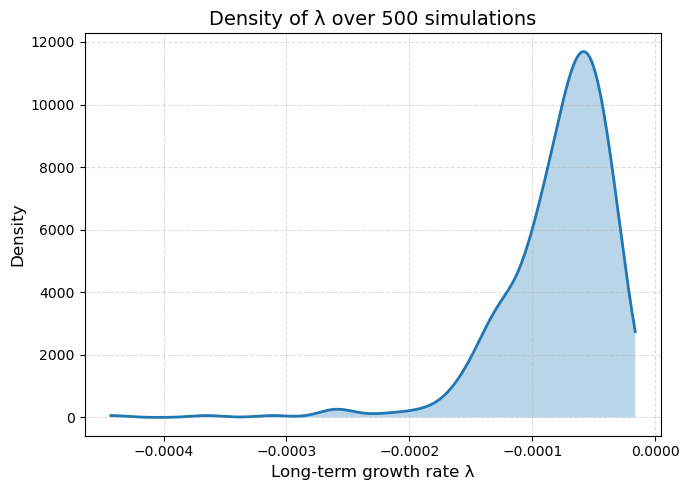

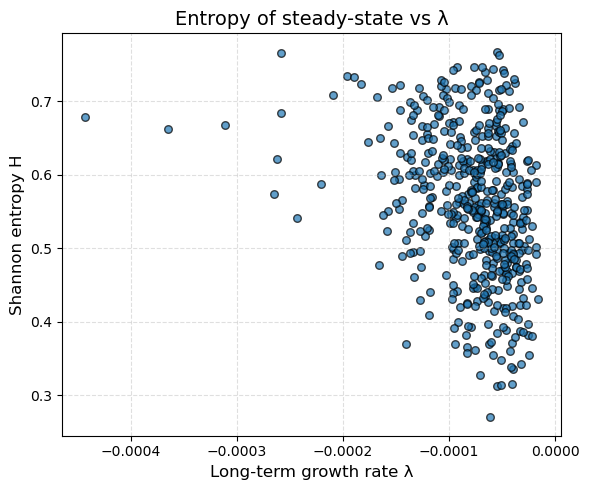

In [ ]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(
        S_plus, S_minus, N_X, N_Y, N_R,
        n_realizations=500,
        dt=1e-3,
        n_steps=250000
    )

In [ ]:
def study_fixed_topology(S_plus, S_minus, N_X, N_Y, N_R,
                         n_realizations=500, dt=1e-3, n_steps=250000):

    lambda_list = []
    H_list = []

    for i in range(n_realizations):
        # construct random kinetics
        Y0, kf, kd = Construct_Kinetics(
            N_X, N_Y, N_R, S_plus, S_minus, degradation=False
        )

        # simulate scalable system
        t_eval, Ystar_traj, Yabs, mus, N_traj = Solve_Scaled_System(
            S_minus, S_plus, Y0, N_X, N_Y, N_R,
            kf, kd, law="MA", dt=dt, n_steps=n_steps
        )

        # compute long-term growth rate λ
        lam = compute_long_term_growth_rate(mus, last_n=100)

        # use last composition vector Ystar_traj[:, -1] compute Shannon entropy
        H = compute_shannon_entropy(Ystar_traj[:, -1])

        # check if finite
        if np.isfinite(lam) and np.isfinite(H):
            lambda_list.append(lam)
            H_list.append(H)

    # λ KDE curve 
    lambda_arr = np.array(lambda_list)
    kde = gaussian_kde(lambda_arr)
    x_vals = np.linspace(lambda_arr.min(), lambda_arr.max(), 300)
    density = kde(x_vals)

    plt.figure(figsize=(7,5))
    plt.plot(x_vals, density, lw=2)
    plt.fill_between(x_vals, density, alpha=0.3)
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.title(f"Density of λ over {len(lambda_arr)} simulations", fontsize=14)
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # H vs λ 
    plt.figure(figsize=(6,5))
    plt.scatter(lambda_list, H_list, s=30, edgecolors='k', alpha=0.7)
    plt.xlabel("Long-term growth rate λ", fontsize=12)
    plt.ylabel("Shannon entropy H", fontsize=12)
    plt.title("Entropy of steady-state vs λ", fontsize=14)
    plt.grid(linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

    return lambda_list, H_list

In [ ]:
S_tot = """
   1  2  3  4  5  6  7  8
1  0  0  0 -1  0  0 -1  0
2  0  1 -1 -1  0  1  0  0
3 -1  0  0  0  0  0  0  1
4 -1  1  0  0 -2 -1  0  0
5  1 -1  1  0  0  1  0 -1
6  1  0  1  0  1  0 -1  1
7  0  0 -1  0  0  0  1  0
8  0  0  0  1  0 -1  0  0
"""

S_plus = """
   1  2  3  4  5  6  7  8
1  0  0  0  0  0  0  0  0
2  0  1  0  0  0  1  0  0
3  0  0  0  0  0  0  0  1
4  0  1  0  0  0  0  0  0
5  1  0  1  0  0  1  0  0
6  1  0  1  0  1  0  0  1
7  0  0  0  0  0  0  1  0
8  0  0  0  1  0  0  0  0
"""

S_minus = """
   1  2  3  4  5  6  7  8
1  0  0  0  1  0  0  1  0
2  0  0  1  1  0  0  0  0
3  1  0  0  0  0  0  0  0
4  1  0  0  0  2  1  0  0
5  0  1  0  0  0  0  0  1
6  0  0  0  0  0  0  1  0
7  0  0  1  0  0  0  0  0
8  0  0  0  0  0  1  0  0
"""

NX = 1
NY = 7
NR = 8

S_tot = parse_matrix(S_tot)
S_plus = parse_matrix(S_plus)
S_minus = parse_matrix(S_minus)

S_tot_inv = invert_S(S_tot)
print("Inverse of S_tot:\n", S_tot_inv)
# check Stot_inv @ Stot ≈ I
print("Check identity:\n", np.round(S_tot_inv.dot(S_tot), 6))

Inverse of S_tot:
 [[ 0.333  0.333  0.     0.333  0.667  0.667  1.     0.667]
 [-1.     0.    -1.     0.    -1.     0.    -1.    -1.   ]
 [-1.    -1.    -1.     0.    -1.     0.    -1.    -2.   ]
 [ 0.     1.     1.     0.     1.     0.     0.     2.   ]
 [-0.667 -0.667 -1.    -0.667 -1.333 -0.333 -1.    -1.333]
 [ 0.     1.     1.     0.     1.     0.     0.     1.   ]
 [-1.    -1.    -1.     0.    -1.     0.     0.    -2.   ]
 [ 0.333  0.333  1.     0.333  0.667  0.667  1.     0.667]]
Check identity:
 [[ 1.001e+00 -1.000e-03  1.000e-03  1.000e-03  1.000e-03  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 1.000e-03 -1.000e-03  1.000e-03  1.000e-03  1.001e+00  0.000e+00
   0.000e+00 -0.000e+00]
 [ 0.000e+00  0.000e+00  0

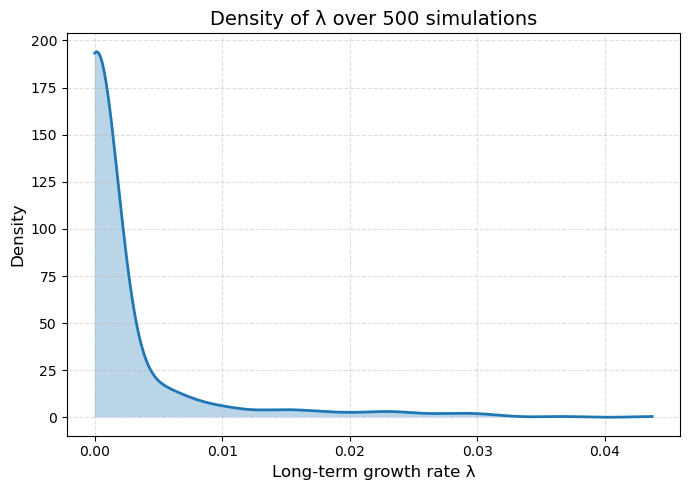

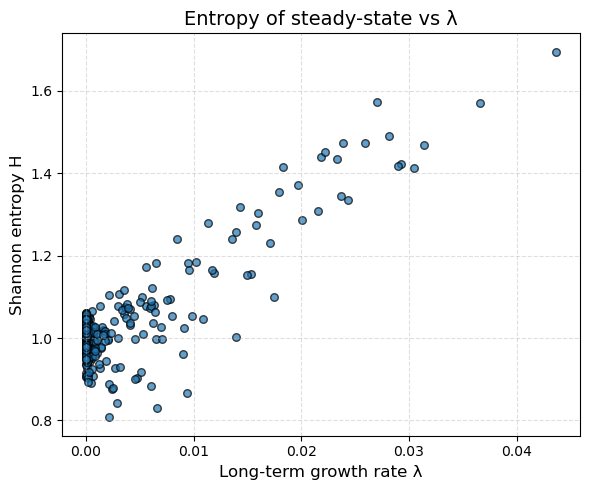

In [ ]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(
        S_plus, S_minus, NX, NY, NR,
        n_realizations=500,
        dt=1e-3,
        n_steps=250000
    )

In [ ]:
S_tot = """
   1  2  3  4  5  6  7  8
1  0  0  0 -1  1  0  0  0
2  0  1  0  0 -1  1  0  1
3 -1  0 -1  0  1  0  1  0
4  0  0  0 -1  0  1  0  0
5  0  0  0  0 -1 -1 -1  1
6  0  0  1  1  0 -1  0  0
7  0  0 -1  1  0  0  0  0
8  1 -2  0  0  0  0  1 -1
"""

S_plus = """
   1  2  3  4  5  6  7  8
1  0  0  0  0  1  0  0  0
2  0  1  0  0  0  1  0  1
3  0  0  0  0  1  0  1  0
4  0  0  0  0  0  1  0  0
5  0  0  0  0  0  0  0  1
6  0  0  1  1  0  0  0  0
7  0  0  0  1  0  0  0  0
8  1  0  0  0  0  0  1  0
"""

S_minus = """
   1  2  3  4  5  6  7  8
1  0  0  0  1  0  0  0  0
2  0  0  0  0  1  0  0  0
3  1  0  1  0  0  0  0  0
4  0  0  0  1  0  0  0  0
5  0  0  0  0  1  1  1  0
6  0  0  0  0  0  1  0  0
7  0  0  1  0  0  0  0  0
8  0  2  0  0  0  0  0  1
"""

NX = 1
NY = 7
NR = 8

S_tot = parse_matrix(S_tot)
S_plus = parse_matrix(S_plus)
S_minus = parse_matrix(S_minus)

S_tot_inv = invert_S(S_tot)
print("Inverse of S_tot:\n", S_tot_inv)
# check Stot_inv @ Stot ≈ I
print("Check identity:\n", np.round(S_tot_inv.dot(S_tot), 6))

Inverse of S_tot:
 [[ 1.     0.667 -0.667 -1.667 -0.333 -0.667  0.     0.333]
 [ 0.     0.333 -0.333 -2.333 -0.667 -1.333 -1.    -0.333]
 [ 0.     0.     0.     1.     0.     1.     0.     0.   ]
 [ 0.     0.     0.     1.     0.     1.     1.     0.   ]
 [ 1.     0.     0.     1.     0.     1.     1.     0.   ]
 [ 0.     0.     0.     2.     0.     1.     1.     0.   ]
 [ 0.     0.667  0.333 -1.667 -0.333 -0.667 -1.     0.333]
 [ 1.     0.667  0.333  1.333  0.667  1.333  1.     0.333]]
Check identity:
 [[ 1.000e+00  1.000e-03  0.000e+00  0.000e+00 -1.000e-03  0.000e+00
  -1.000e-03  1.000e-03]
 [ 0.000e+00  9.990e-01  0.000e+00  0.000e+00  1.000e-03  0.000e+00
   1.000e-03 -1.000e-03]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  1.000e+00  0.000e+00
   0.000e+00  0.000e+00]
 [ 0.000e+00  0.000e+00  0

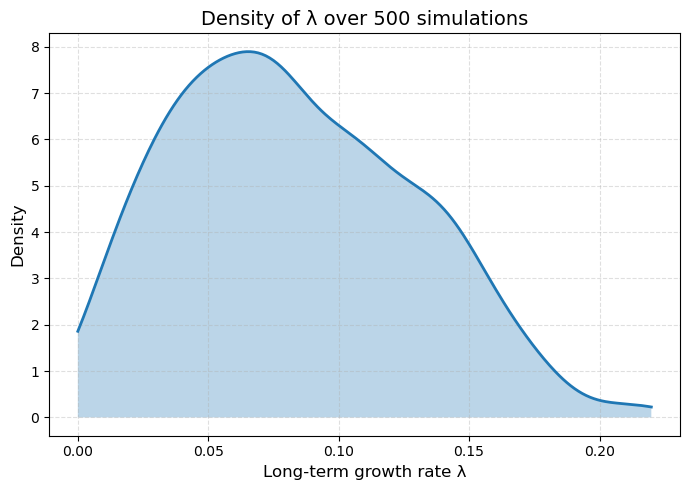

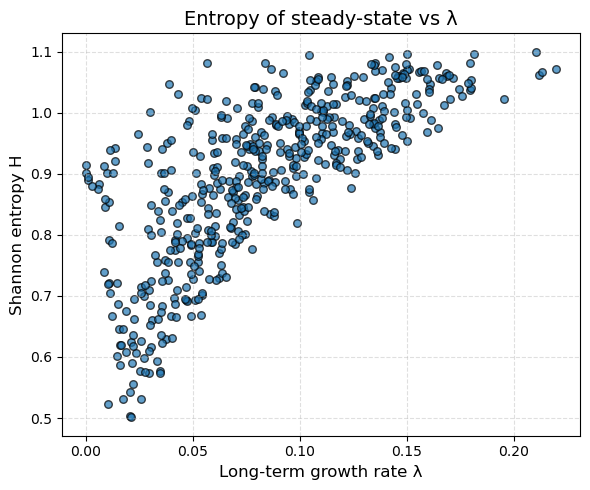

In [ ]:
if __name__ == "__main__":

    lambda_vals, H_vals = study_fixed_topology(
        S_plus, S_minus, NX, NY, NR,
        n_realizations=500,
        dt=1e-3,
        n_steps=250000
    )

In [ ]:
'''
So the idea is now: for a fixed topology,
If the production pathway is blocked
(means) that the inverse of S_tot have negative elements corresponding to X species
means it takes infinite time to grow or shrink

And if the pathway is not blocked, it can achieve expotential growth in finite time
'''

In [14]:
stot2 ="""
     1   2   3   4   5   6   7   8   9   10
1    0   0   1   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0  -1   0   0
3    0   0   0   0   0   0  -1   0   0   0
4    0  -1   0   0   0  -1   0   1   0   0
5    0   0   1   0   0   0   0   0  -1  -1
6    0   1   0   1   0   0  -1   0   2   0
7    1   0   0   0   0   0   1   0  -1   0
8    0   0   0   0   0   1   0  -1   0  -1
9   -2   1  -1  -1   1   0   0   0   0   0
10   0   0   0   0  -1  -1   0   0   0   1
"""

s_plus2 = """
    1   2   3   4   5   6   7   8   9   10
1    0   0   1   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0   0   0   0
3    0   0   0   0   0   0   0   0   0   0
4    0   0   0   0   0   0   0   1   0   0
5    0   0   1   0   0   0   0   0   0   0
6    0   1   0   1   0   0   0   0   2   0
7    1   0   0   0   0   0   1   0   0   0
8    0   0   0   0   0   1   0   0   0   0
9    0   1   0   0   1   0   0   0   0   0
10   0   0   0   0   0   0   0   0   0   1
"""

s_minus2 = """
    1   2   3   4   5   6   7   8   9   10
1    0   0   0   0   0   0   0   0   0   0
2    0   0   0   0   0   0   0   1   0   0
3    0   0   0   0   0   0   1   0   0   0
4    0   1   0   0   0   1   0   0   0   0
5    0   0   0   0   0   0   0   0   1   1
6    0   0   0   0   0   0   1   0   0   0
7    0   0   0   0   0   0   0   0   1   0
8    0   0   0   0   0   0   0   1   0   1
9    2   0   1   1   0   0   0   0   0   0
10   0   0   0   0   1   1   0   0   0   0
"""

NX = 3
NY = 7
NR = 10

S_tot2 = parse_matrix(stot2)
S_plus2 = parse_matrix(s_plus2)
S_minus2 = parse_matrix(s_minus2)


In [ ]:
S_tot_inv2 = invert_S(S_tot2)
print("Inverse of S_tot2:\n", S_tot_inv2)
# check Stot_inv @ Stot ≈ I
print("Check identity:\n", np.round(S_tot_inv2.dot(S_tot2), 6))

Inverse of S_tot2:
 [[ 1.5 -0.5  1.5  1.  -1.   0.5  2.   1.5  0.5  0.5]
 [ 0.5 -0.5  0.5  0.   0.   0.5  1.   0.5  0.5  0.5]
 [ 1.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [-3.5  1.5 -2.5 -2.   2.  -0.5 -3.  -3.5 -1.5 -1.5]
 [ 0.   1.   0.   0.   0.   0.   0.  -1.   0.  -1. ]
 [-0.5 -0.5 -0.5 -1.   0.  -0.5 -1.  -0.5 -0.5 -0.5]
 [ 0.   0.  -1.   0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -1.   0.   0.   0.   0.   0.   0.   0.   0. ]
 [ 1.5 -0.5  0.5  1.  -1.   0.5  1.   1.5  0.5  0.5]
 [-0.5  0.5 -0.5 -1.   0.  -0.5 -1.  -1.5 -0.5 -0.5]]
Check identity:
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


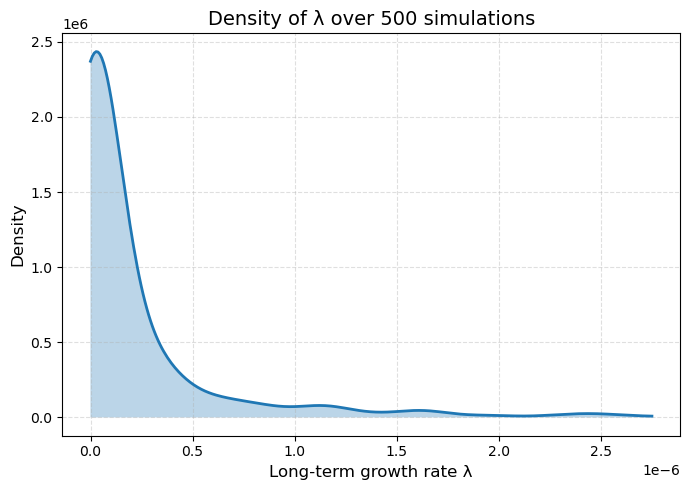

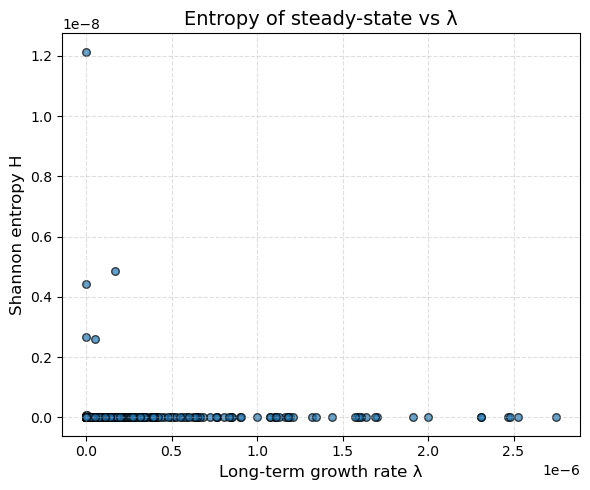

In [ ]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(
        S_plus2, S_minus2, NX, NY, NR,
        n_realizations=500,
        dt=1e-3,
        n_steps=250000
    )

In [ ]:
"""
obviously, among the topology above, only one species can grow, 
after check, it's species Y_4, which is species 7
"""

In [ ]:
"""
Let's find one reversible network with non-negative col among first N_X cols in inverse Martix
However, it's super hard and let's just find ones with non-zero long-term growth rate networks in our data
and ignore if they are inversible or not
"""

In [ ]:
'''
Compute pseudo-inverse of S and make the first N_X colunm linear independent
'''

def compute_block_pseudoinverse(S_minus: np.ndarray,
                                 S_plus: np.ndarray,
                                 N_X: int,
                                 decimals: int = 3,
                                 tol: float = 1e-7) -> np.ndarray:
    """
    Compute a pseudoinverse S^ such that for S = S_plus - S_minus,
    the block (S @ S^)[0:N_X, 0:N_X] is exactly the identity.
    Other entries of S @ S^ are unconstrained.

    Parameters
    ----------
    S_minus : np.ndarray, shape (m, n)
    S_plus  : np.ndarray, shape (m, n)
    N_X     : int
        Size of the top-left identity block in S @ S^.
    decimals: int, optional
        Number of decimal places for rounding output.
    tol     : float, optional
        Threshold below which values are set to zero.

    Returns
    -------
    S_pinv : np.ndarray, shape (n, m)
        The pseudoinverse meeting the block constraint.
    """
    # Build stoichiometric matrix S = S_plus - S_minus
    S = np.asarray(S_plus, float) - np.asarray(S_minus, float)
    m, n = S.shape

    # Check submatrix rank for feasibility
    A_sub = S[:N_X, :]  # top N_X rows
    rank_sub = matrix_rank(A_sub)
    if rank_sub < N_X:
        raise np.linalg.LinAlgError(
            f"Cannot form {N_X}x{N_X} identity block: rank of top rows is {rank_sub} < {N_X}")

    # Compute pseudoinverse of submatrix and full matrix
    A_sub_pinv = pinv(A_sub)      # shape (n, N_X)
    S_full_pinv = pinv(S)         # shape (n, m)

    # Assemble custom pseudoinverse
    S_pinv = np.zeros((n, m), float)
    S_pinv[:, :N_X] = A_sub_pinv
    if m > N_X:
        S_pinv[:, N_X:] = S_full_pinv[:, N_X:]

    # Compute block result
    SS = S @ S_pinv  # shape (m, m)

    # Clean small entries and round
    def clean(mat):
        mat[np.abs(mat) < tol] = 0.0
        return np.round(mat, decimals)

    S_clean = clean(S.copy())
    Sp_clean = clean(S_pinv.copy())
    SS_clean = clean(SS.copy())

    # Print results
    print("Cleaned S matrix:")
    print(S_clean)
    print("\nCustom pseudoinverse S^:")
    print(Sp_clean)
    print("\nProduct S @ S^:")
    print(SS_clean)
    print(f"\nTop-left {N_X}x{N_X} block (should be identity):")
    print(SS_clean[:N_X, :N_X])

    # Verify block identity
    I_block = np.eye(N_X)
    if not np.allclose(SS_clean[:N_X, :N_X], I_block, atol=tol):
        print(f"Warning: Top-left block deviates from identity by tol={tol}")

    # Output final pseudoinverse
    rank_S = matrix_rank(S)
    rank_Sp = matrix_rank(Sp_clean)
    print(f"\nRank of S: {rank_S}, rank of S^: {rank_Sp}")

    return Sp_clean

In [3]:
'''
This Matrix is from realization 140, order 2
NX=3
NY=3
NR=5
alpha = beta = 0.794
'''
S140_minus = np.array([
[0,0,1,0,0],
[1,0,0,0,0],
[0,1,0,0,0],
[1,1,0,0,0],
[0,0,1,0,2],
[0,0,0,2,0]
])

S140_plus = np.array([
[0,0,0,1,0],
[0,0,0,0,1],
[0,0,0,0,0],
[0,0,1,0,0],
[0,0,0,1,0],
[1,1,0,0,1]
])

N_X = 3
N_Y = 3
N_R = 5

S_pinv = compute_block_pseudoinverse(S140_minus, S140_plus, N_X)

Enforced nonnegative pathway in column 0
Cleaned S:
[[ 0.  0. -1.  1.  0.]
 [-1.  0.  0.  0.  1.]
 [ 0. -1.  0.  0.  0.]
 [-1. -1.  1.  0.  0.]
 [ 0.  0. -1.  1. -2.]
 [ 1.  1.  0. -2.  1.]]

Custom pseudoinverse S^:
[[ 0.    -0.5    0.    -0.364 -0.5   -0.182]
 [ 0.     0.    -1.    -0.182 -0.    -0.091]
 [ 0.    -0.     0.     0.091 -0.5   -0.455]
 [ 1.     0.     0.    -0.273 -0.5   -0.636]
 [ 0.     0.5   -0.    -0.182 -0.5   -0.091]]

Product S @ S^:
[[ 1.     0.     0.    -0.364  0.    -0.182]
 [ 0.     1.     0.     0.182  0.     0.091]
 [ 0.     0.     1.     0.182  0.     0.091]
 [ 0.     0.5    1.     0.636  0.    -0.182]
 [ 1.    -1.     0.     0.     1.     0.   ]
 [-2.     0.    -1.    -0.182  0.     0.909]]

Top-left 3x3 block (should be identity):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Rank of S: 5, Rank of S^: 5


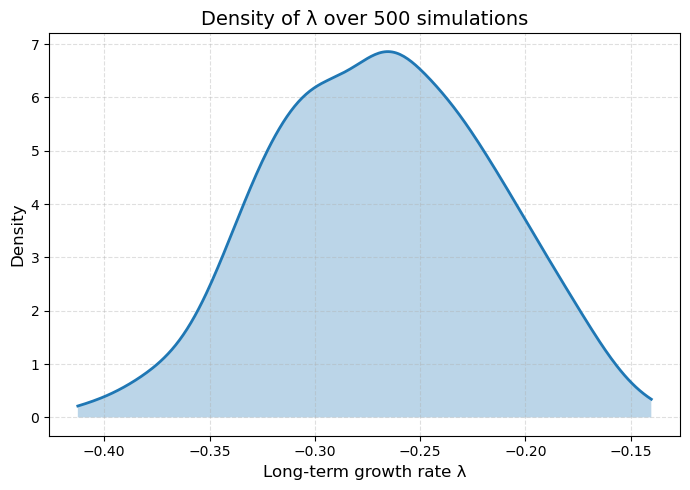

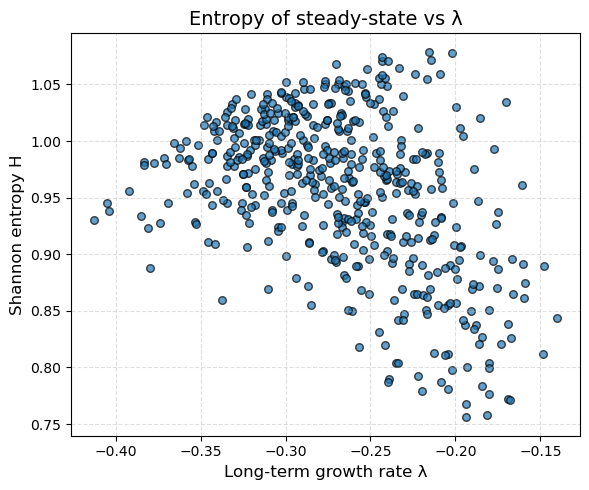

In [ ]:
if __name__ == "__main__":
    lambda_vals, H_vals = study_fixed_topology(
        S140_plus, S140_minus, N_X, N_Y, N_R,
        n_realizations=500,
        dt=1e-3,
        n_steps=250000
    )